In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit.extensions import (XGate, YGate, ZGate, HGate, SGate, SdgGate, CXGate,
                               CYGate, CZGate, SwapGate, U3Gate)
import numpy as np

def random_circuit(num_qubits, depth, seed=None):  # pylint:disable=unused-argument

    one_q_ops = [XGate, YGate, ZGate, HGate, SGate, SdgGate]
    two_q_ops = [CXGate, CYGate,  CZGate, SwapGate]

    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng = np.random.RandomState(seed)
    qc = QuantumCircuit(num_qubits,num_qubits)
    # apply arbitrary random operations at every depth
    for _ in range(depth):
        remaining_qubits = list(range(num_qubits))
        while remaining_qubits:
            max_possible_operands = min(len(remaining_qubits), 2)
            num_operands = rng.choice(range(max_possible_operands)) + 1
            rng.shuffle(remaining_qubits)
            operands = remaining_qubits[:num_operands]
            remaining_qubits = [q for q in remaining_qubits if q not in operands]
            if num_operands == 1:
                operation = rng.choice(one_q_ops)
            elif num_operands == 2:
                operation = rng.choice(two_q_ops)
            register_operands = [i for i in operands]
            op = operation()

            qc.append(op, qargs=register_operands, cargs=None)
    qc.barrier(range(num_qubits))
    qc.measure(range(num_qubits), range(num_qubits))

    return qc


def replace_single(qc, seed=None):
    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng = np.random.RandomState(seed)
        
    one_q_ops = [XGate, YGate, ZGate, HGate, SGate, SdgGate]
    for i, (gate, qubits, clbits) in enumerate(qc.data):
        if any(isinstance(gate, x) for x in one_q_ops):
            angles = [rng.uniform(0, 2 * np.pi) for x in range(3)]
            qc.data[i] = (U3Gate(*angles), qubits, clbits)

    return qc

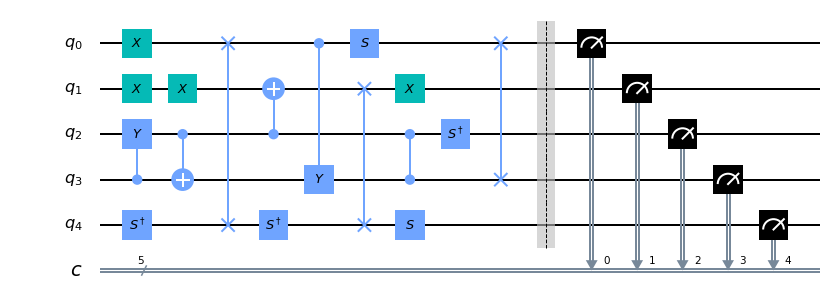

In [2]:
circuit = random_circuit(5, 5, 0)
circuit.draw(output='mpl')

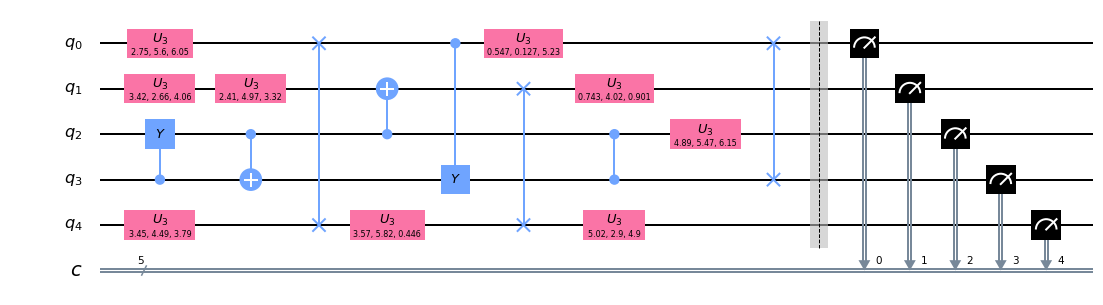

In [3]:
new_circuit = replace_single(circuit, 0)
new_circuit.draw(output='mpl')

In [4]:
circuit = random_circuit(100, 100, 0)

In [5]:
from qiskit import Aer, assemble

backend = Aer.get_backend('qasm_simulator')
backend_options = {"method": "stabilizer", "shots": 100}

In [6]:
import time
start = time.time()
job = backend.run(assemble(circuit), backend_options=backend_options)
result = job.result()
duration = time.time() - start
print(duration)

1.1618752479553223


In [7]:
result.get_counts()

{'1100000001011101000111010011100011011011010101111011010101000010101010001010010001000001101110000101': 1,
 '0001000101110001000111101010010010100010010010011011001001001001110111110010011110011010100001000100': 1,
 '0010101111100101111100100111101001001110010000000010001010100010101111000011000101000110000000100010': 1,
 '0011101010011110110100101001000010011001011000101000011111111100100101000010011011110000111000001010': 1,
 '0100011100100111101001110110011010100000001100111100001000110101110111010001010101001111100010000100': 1,
 '1010001101100000101000000011001111110110001011101100101011011100011100011110011101100101110101110010': 1,
 '1100101000011110100001111010111011011001000110001001010101100011100000011101000101110000111000101101': 1,
 '0011101010001001100001011111100100011000110001100011110001000010111101010010111011110001011010000001': 1,
 '0101000110100001000101000110110010001111010100100000101000000100101001100000111110100111011111001011': 1,
 '11100010100111000000010001

In [8]:
from qiskit import Aer, assemble
import time

backend_1 = Aer.get_backend('qasm_simulator')
backend_options_1 = {"method": "stabilizer", "shots": 100}
backend_2 = Aer.get_backend('qasm_simulator')
backend_options_2 = {"method": "statevector", "shots": 100}

duration_statevector = []
duration_stablizer = []
num_qubits = 22
depth = 20
averages = 20
for n in range(1,num_qubits):
    duration_1 = []
    duration_2 = []
    for run in range(averages):
        circuit_1 = random_circuit(n, depth)
        circuit_2 = replace_single(circuit_1)

        start = time.time()
        job = backend_1.run(assemble(circuit_1), backend_options=backend_options_1)
        result = job.result()
        duration_1.append(time.time() - start)


        start = time.time()
        job = backend_2.run(assemble(circuit_2), backend_options=backend_options_2)
        result = job.result()
        duration = time.time() - start
        duration_2.append(time.time() - start)
    duration_stablizer.append(np.mean(duration_1))
    duration_statevector.append(np.mean(duration_2))
    

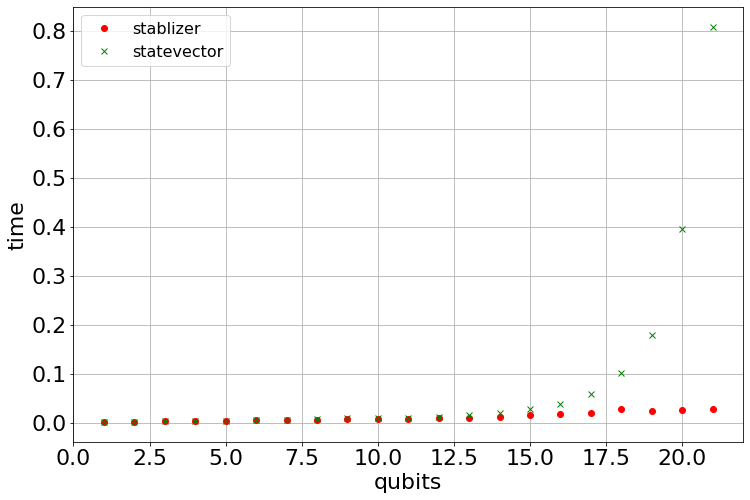

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
plt.plot(range(1,num_qubits),duration_stablizer,'ro', label= 'stablizer')
plt.plot(range(1, num_qubits),duration_statevector,'gx', label= 'statevector')
plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.xlabel('qubits')
plt.ylabel('time')
plt.show()